<a href="https://colab.research.google.com/github/nbche/AIFFEL_quest_cr/blob/main/Exploration_CR23_4_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install sumy

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 68.1 MB/s eta 0:00:00
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21691 sha256=8170159dacf137613e429a2c3e339cbcab665520d54449249d1cf74d471148ca
  Stored in directory: /root/.cache/pip/wheels/4d/57/58/7e3d7fedf51fe248b7fcee3df6945ae28638e22cddf01eb92b
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=a62ca76573801990dab12feea6049911597c596e3f8e72d186ab7b729083308b
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built breadability docopt


In [4]:
!pip install summa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54387 sha256=252c13bbeb1e3d2abe8900ac3346c5add3a30e88ef388b0f7ddb985fc6ffaacf
  Stored in directory: /root/.cache/pip/wheels/10/2d/7a/abce87c4ea233f8dcca0d99b740ac0257eced1f99a124a0e1f
Successfully built summa


In [8]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 10.2 MB/s eta 0:00:00


# 라이브러리 다운로드

In [9]:
from importlib.metadata import version
import nltk
import tensorflow
# import summa # This line is causing the error
import sumy # Use sumy instead of summa for text summarization
import pandas as pd
#------------------------------------#
import nltk   ## 데이터 전처리를 위한 라이브러리
nltk.download('stopwords')

import contractions
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

#------------------------------------#
from tensorflow.keras.models import Model ## 모델링을 위한 라이브러리
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.optimizers import Adam

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 1. 데이터 수집하기

In [10]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [11]:
print(data.sample(10))
print("-"*20)
print("데이터 프레임 정보:")
print(data.info())
print("-"*20)
print("\n기본 통계 요약:")
print(data.describe())

# headline 열에서 가장 긴 문자열의 행 번호 찾기
longest_headline_index = data['headlines'].str.len().idxmax()
longest_headline_row = data.iloc[longest_headline_index]
longest_headline = longest_headline_row['headlines']
longest_headline_length = len(longest_headline)

# text 열에서 가장 긴 문자열의 행 번호 찾기
longest_text_index = data['text'].str.len().idxmax()
longest_text_row = data.iloc[longest_text_index]
longest_text = longest_text_row['text']
longest_text_length = len(longest_text)

# 결과 출력
print(f"가장 긴 헤드라인 (행 번호 {longest_headline_index}, 길이 {longest_headline_length}):")
print(longest_headline)

print(f"\n가장 긴 텍스트 (행 번호 {longest_text_index}, 길이 {longest_text_length}):")
print(longest_text)
print("-"*20)
row_17829 = data.iloc[17829][0]
print(row_17829)

                                               headlines  \
9552   AstraZeneca starts search for CEO Soriot's suc...   
70645  7.8 earthquake triggered 'slow motion' quakes ...   
87565  US firm 1st to launch orbital-class rocket fro...   
34606  Cows may be largest mammals left on Earth in 2...   
52009    Kerala CM meets man on 767th day of his protest   
54319  Apple patents long-range wireless charging tec...   
41778  CBSE to reconduct Class 12 Economics, Class 10...   
60820  Twitter to revoke verification badge if users ...   
79930  India's only brain museum to get a digital mak...   
18916  FB should face laws over failure of kids' safe...   

                                                    text  
9552   Pharmaceutical giant AstraZeneca has reportedl...  
70645  A US-based study has documented the first inst...  
87565  American aerospace corporation Rocket Lab has ...  
34606  Based on continuing trend of size-biased extin...  
52009  Kerala CM Pinarayi Vijayan met and as

<ipython-input-11-8f5434605802>:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_17829 = data.iloc[17829][0]


# Step 2. 데이터 전처리하기 (추상적 요약)

## 1) 데이터 정리하기

In [12]:
print('전체 샘플수 :', (len(data)))
print('-'*20)
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())  #중복 샘플과 NULL 값이 존재하는 샘플 제거
print('-'*20)
data.drop_duplicates(subset = ['text'], inplace=True) # inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
print('전체 샘플수 :', (len(data)))
print('-'*20)
print(data.isnull().sum())
print('-'*20)
print('불용어 개수 :', len(stopwords.words('english') ))  #텍스트 정규화와 불용어 제거
print(stopwords.words('english'))

전체 샘플수 : 98401
--------------------
Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
--------------------
전체 샘플수 : 98360
--------------------
headlines    0
text         0
dtype: int64
--------------------
불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my'

In [13]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    # Fix: Use contractions.fix() to expand contractions
    sentence = contractions.fix(sentence) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [14]:
clean_text = []
clean_text = data['text'].apply(lambda x: preprocess_sentence(x))
clean_headlines = []
clean_headlines = data['headlines'].apply(lambda x: preprocess_sentence(x),False)

# 전처리 후 출력
print("전처리 후 결과: ", clean_text[:5])
print('-'*20)
print("전처리 후 결과: ", clean_headlines[:5])

<ipython-input-14-9e0a96684609>:4: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  clean_headlines = data['headlines'].apply(lambda x: preprocess_sentence(x),False)


전처리 후 결과:  0    saurav kant alumnus upgrad iiit pg program mac...
1    kunal shah credit card bill payment platform c...
2    new zealand defeated india wickets fourth odi ...
3    aegon life iterm insurance plan customers enjo...
4    speaking sexual harassment allegations rajkuma...
Name: text, dtype: object
--------------------
전처리 후 결과:  0     upgrad learner switches career ml al salary hike
1     delhi techie wins free food swiggy one year cred
2    new zealand end rohit sharma led india match w...
3    aegon life iterm insurance plan helps customer...
4             known hirani yrs metoo claims true sonam
Name: headlines, dtype: object


In [15]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
# Null 값 개수 확인하기
print(data.isnull().sum())
# Null 값 제거하기
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

headlines    0
text         0
dtype: int64
전체 샘플수 : 98360


98360
98360
텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09534363562424
기사요약 최소 길이 : 1
기사요약 최대 길이 : 13
기사요약 평균 길이 : 7.1366205774705165


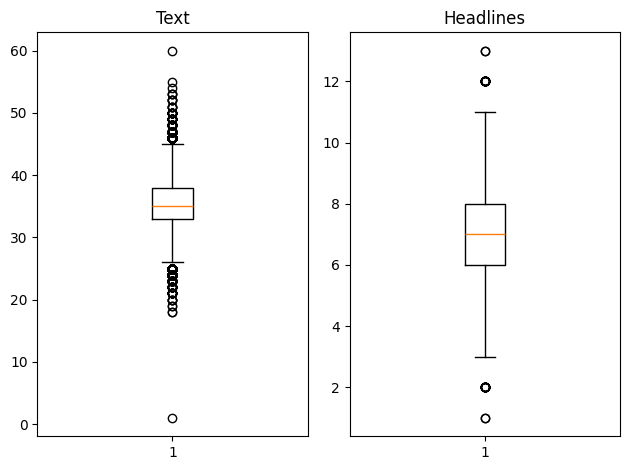

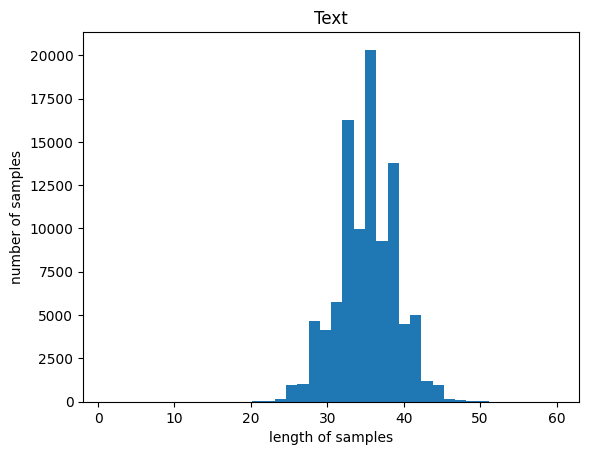

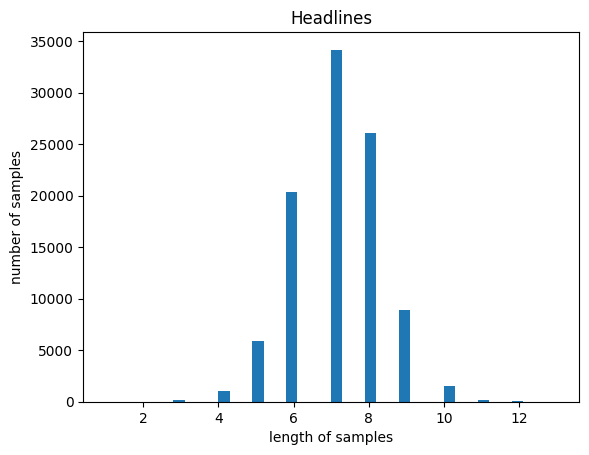

In [16]:
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print(len(data["text"]))
print(len(data["headlines"]))

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('기사요약 최소 길이 : {}'.format(np.min(headlines_len)))
print('기사요약 최대 길이 : {}'.format(np.max(headlines_len)))
print('기사요약 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [17]:
# 기사 요약에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al salary hi...
1,delhi techie wins free food swiggy one year cred,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food swiggy on...,delhi techie wins free food swiggy one year cr...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken


## 2) 훈련데이터와 테스트 데이터로 나누기

In [18]:
encoder_input = np.array(data['text']) # 인코더의 입력을 numpy 타입으로 저장
decoder_input = np.array(data['decoder_input']) # 디코더의 입력을 numpy 타입으로 저장
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블을 numpy 타입으로 저장

In [19]:
# 훈련 데이터와 테스트 데이터로 분리
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

# 위의 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

[18637 17220 84748 ... 59281 79250   350]


In [20]:
# 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)
print('-'*20)
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

테스트 데이터의 수 : 19672
--------------------
훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


## 3) 정수인코딩

In [21]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [22]:
threshold = 5    #등장 빈도수가 5회 미만인 단어 제외
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69749
등장 빈도가 4번 이하인 희귀 단어의 수: 43386
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 26363
단어 집합에서 희귀 단어의 비율: 62.20304233752455
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.665034205302772


In [23]:
src_vocab = 26000 ## 희귀 단어 제외시킨 단어 집단으로 크기 제한
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 26,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [24]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[5, 420, 21, 2632, 4723, 1935, 42, 55, 712, 39, 152, 14, 1801, 72, 4723, 382, 61, 380, 13796, 1930, 12, 334, 5, 423, 1831, 2977, 42, 1525, 8028, 978, 5, 21, 420, 372, 2, 42, 382], [171, 2282, 414, 29, 301, 425, 270, 20714, 117, 200, 41, 2282, 81, 313, 3314, 200, 20715, 1885, 56, 922, 1885, 1295, 474, 2282, 4, 288, 1139, 727, 68, 698, 2], [718, 2179, 7164, 386, 2992, 408, 58, 479, 94, 2511, 4724, 1049, 1658, 607, 225, 2125, 69, 6564, 1086, 92, 574, 3, 1672, 715, 480, 617, 3926, 217, 106, 479, 718, 6, 2217, 1219]]


In [25]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print(decoder_input_train[:3])

['sostoken us state secy pompeo arrives pak meet pm imran khan'
 'sostoken dravid became wicketkeeper break school cricket team'
 'sostoken whole foods shares surge amazon bn takeover']


In [26]:
threshold = 3
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29983
등장 빈도가 2번 이하인 희귀 단어의 수: 14657
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 15326
단어 집합에서 희귀 단어의 비율: 48.88436780842477
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.9186935371785965


In [27]:
tar_vocab = 15000  ## 희귀 단어 제외시킨 단어 집단으로 크기 제한
tar_tokenizer = Tokenizer(num_words=tar_vocab) # 단어 집합의 크기를 15,000으로 제한
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 4, 159, 692, 10296, 3778, 27, 416, 6, 938, 109], [1, 1313, 2018, 5308, 775, 127, 139, 59], [1, 4280, 6357, 73, 4281, 202, 123, 4908], [1, 386, 78, 3887, 10, 178, 55, 191], [1, 8685, 11451, 4909, 1330, 357]]
target
decoder  [[4, 159, 692, 10296, 3778, 27, 416, 6, 938, 109, 2], [1313, 2018, 5308, 775, 127, 139, 59, 2], [4280, 6357, 73, 4281, 202, 123, 4908, 2], [386, 78, 3887, 10, 178, 55, 191, 2], [8685, 11451, 4909, 1330, 357, 2]]


In [28]:
# Null 값의 자료 지우기

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))


삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78687
훈련 레이블의 개수 : 78687
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


In [29]:
# 패딩하기
text_max_len = 60
headlines_max_len = 13

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

# Step 3. LTSM 모델 사용하기 (추상적 요약)

## 1) 모델 설계하기

In [ ]:
# LSTM 모델 구축

embedding_dim = 128  # Input dimension: Size of the vocabulary
latent_dim = 256  # Hidden state dimension of the LSTM

# 인코더
encoder_inputs = Input(shape=(text_max_len,))
# Fix: Provide output_dim argument to Embedding layer
enc_emb = Embedding(src_vocab + 1, embedding_dim, mask_zero=True)(
    encoder_inputs
)  # src_vocab + 1 is used to account for padding index (0)
encoder_lstm, state_h, state_c = LSTM(latent_dim, return_state=True)(enc_emb)
encoder_states = [state_h, state_c]

# 디코더
# Fix: Change the input shape to (headlines_max_len,)
decoder_inputs = Input(shape=(headlines_max_len,))
# Fix: Provide output_dim argument to Embedding layer
dec_emb = Embedding(tar_vocab + 1, embedding_dim, mask_zero=True)(
    decoder_inputs
)  # tar_vocab + 1 is used to account for padding index (0)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(
    tar_vocab + 1, activation="softmax"
)  # tar_vocab + 1 is used to account for padding index (0)
decoder_outputs = decoder_dense(decoder_outputs)

# 모델 정의
model_lstm = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model_lstm.summary()

# 모델 컴파일
model_lstm.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 60)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 60, 128)        │      3,328,128 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 60)             │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 13, 128)        │      1,920,128 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 256), (None,   │        394,240 │ embedding[0][0],       │
│                           │ 256), (None, 256)]     │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 13, 256),      │        394,240 │ embedding_1[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 13, 15001)      │      3,855,257 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 9,891,993 (37.73 MB)

 Trainable params: 9,891,993 (37.73 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 모델 훈련
batch_size = 256
epochs = 50

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='best_lstm_model.h5', monitor='val_loss', save_best_only=True)

history_lstm = model_lstm.fit([encoder_input_train, decoder_input_train], decoder_target_train,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
                    callbacks=[early_stopping, checkpoint])

Epoch 1/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.0757 - loss: 8.0031

308/308 ━━━━━━━━━━━━━━━━━━━━ 75s 224ms/step - accuracy: 0.0757 - loss: 8.0019 - val_accuracy: 0.0809 - val_loss: 7.3122
Epoch 2/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.0820 - loss: 7.2781

308/308 ━━━━━━━━━━━━━━━━━━━━ 83s 236ms/step - accuracy: 0.0820 - loss: 7.2780 - val_accuracy: 0.0842 - val_loss: 7.1479
Epoch 3/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.0852 - loss: 7.0655

308/308 ━━━━━━━━━━━━━━━━━━━━ 80s 230ms/step - accuracy: 0.0852 - loss: 7.0654 - val_accuracy: 0.0886 - val_loss: 6.9163
Epoch 4/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.0913 - loss: 6.7571

308/308 ━━━━━━━━━━━━━━━━━━━━ 70s 229ms/step - accuracy: 0.0913 - loss: 6.7569 - val_accuracy: 0.0969 - val_loss: 6.6034
Epoch 5/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.1000 - loss: 6.4135

308/308 ━━━━━━━━━━━━━━━━━━━━ 82s 229ms/step - accuracy: 0.1000 - loss: 6.4134 - val_accuracy: 0.1035 - val_loss: 6.3701
Epoch 6/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.1082 - loss: 6.0992

308/308 ━━━━━━━━━━━━━━━━━━━━ 84s 236ms/step - accuracy: 0.1082 - loss: 6.0991 - val_accuracy: 0.1107 - val_loss: 6.1488
Epoch 7/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.1163 - loss: 5.8091

308/308 ━━━━━━━━━━━━━━━━━━━━ 72s 235ms/step - accuracy: 0.1163 - loss: 5.8090 - val_accuracy: 0.1158 - val_loss: 5.9818
Epoch 8/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.1243 - loss: 5.5731

308/308 ━━━━━━━━━━━━━━━━━━━━ 73s 236ms/step - accuracy: 0.1243 - loss: 5.5731 - val_accuracy: 0.1214 - val_loss: 5.8397
Epoch 9/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.1329 - loss: 5.3371

308/308 ━━━━━━━━━━━━━━━━━━━━ 73s 236ms/step - accuracy: 0.1329 - loss: 5.3371 - val_accuracy: 0.1267 - val_loss: 5.7195
Epoch 10/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.1414 - loss: 5.1188

308/308 ━━━━━━━━━━━━━━━━━━━━ 80s 230ms/step - accuracy: 0.1414 - loss: 5.1188 - val_accuracy: 0.1308 - val_loss: 5.6262
Epoch 11/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.1508 - loss: 4.9062

308/308 ━━━━━━━━━━━━━━━━━━━━ 71s 230ms/step - accuracy: 0.1508 - loss: 4.9063 - val_accuracy: 0.1341 - val_loss: 5.5468
Epoch 12/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.1601 - loss: 4.7070

308/308 ━━━━━━━━━━━━━━━━━━━━ 82s 230ms/step - accuracy: 0.1601 - loss: 4.7070 - val_accuracy: 0.1369 - val_loss: 5.4849
Epoch 13/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.1689 - loss: 4.5225

308/308 ━━━━━━━━━━━━━━━━━━━━ 84s 237ms/step - accuracy: 0.1689 - loss: 4.5226 - val_accuracy: 0.1396 - val_loss: 5.4399
Epoch 14/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.1779 - loss: 4.3456

308/308 ━━━━━━━━━━━━━━━━━━━━ 80s 229ms/step - accuracy: 0.1779 - loss: 4.3457 - val_accuracy: 0.1422 - val_loss: 5.4077
Epoch 15/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.1880 - loss: 4.1668

308/308 ━━━━━━━━━━━━━━━━━━━━ 70s 228ms/step - accuracy: 0.1880 - loss: 4.1669 - val_accuracy: 0.1428 - val_loss: 5.3787
Epoch 16/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.1978 - loss: 4.0043

308/308 ━━━━━━━━━━━━━━━━━━━━ 84s 236ms/step - accuracy: 0.1978 - loss: 4.0044 - val_accuracy: 0.1442 - val_loss: 5.3646
Epoch 17/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 82s 235ms/step - accuracy: 0.2082 - loss: 3.8414 - val_accuracy: 0.1465 - val_loss: 5.3710
Epoch 18/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 82s 235ms/step - accuracy: 0.2179 - loss: 3.6856 - val_accuracy: 0.1466 - val_loss: 5.3726
Epoch 19/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 82s 236ms/step - accuracy: 0.2299 - loss: 3.5293 - val_accuracy: 0.1477 - val_loss: 5.3922


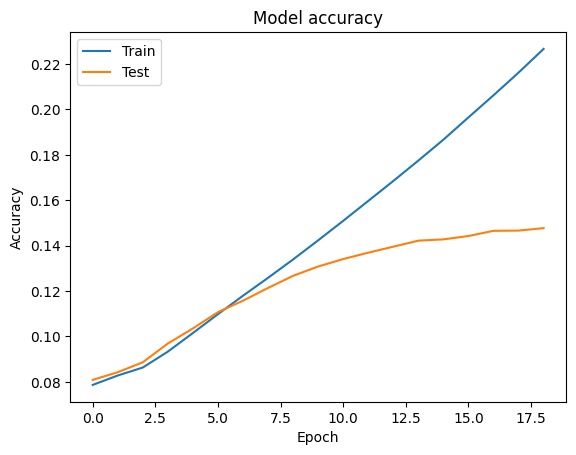

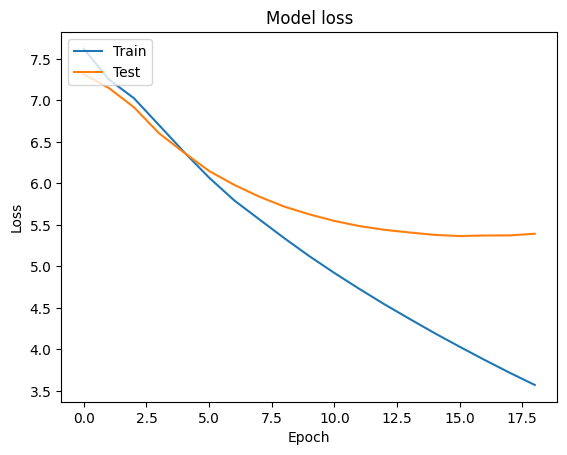

In [ ]:
import matplotlib.pyplot as plt

# 학습 결과 시각화
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 손실 그래프 시각화
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [33]:
embedding_dim = 128  # Input dimension: Size of the vocabulary
latent_dim = 256  # Hidden state dimension of the LSTM

# 인코더 모델
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)

# 디코더 상태 초기화를 위한 인풋 정의
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 임베딩 및 LSTM 레이어
dec_emb2 = Embedding(tar_vocab + 1, embedding_dim, mask_zero=True)(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

# 디코더 모델
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs2] + decoder_states2)

# 시퀀스를 텍스트로 변환
# Fix: Replace 'tokenizer' with 'tar_tokenizer'
reverse_word_map = dict(map(reversed, tar_tokenizer.word_index.items()))

def seq2summary(seq):
    summary = ''
    for item in seq:
        if item == 0:
            break
        if item in reverse_word_map:
            summary = summary + reverse_word_map[item] + ' '
    return summary.strip()

def decode_sequence(input_seq):
    # 인코더 상태
    states_value = encoder_model.predict(input_seq)

    # 디코더 시작 인풋으로는 start token을 사용
    target_seq = np.zeros((1, 1))
    # Fix: Replace 'tokenizer' with 'tar_tokenizer'
    target_seq[0, 0] = tar_tokenizer.word_index['start']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # 샘플링의 토큰 선택
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_word_map[sampled_token_index]
        decoded_sentence += ' ' + sampled_char

        # 종료 조건: 최대 길이에 도달하거나 stop token을 생성
        if (sampled_char == 'end' or
           len(decoded_sentence) > headlines_max_len):
            stop_condition = True

        # 업데이트된 타겟 시퀀스
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 업데이트된 디코더 상태
        states_value = [h, c]

    return decoded_sentence.strip()

# 테스트 데이터에 대해 모델 사용 예시
for seq_index in range(10):
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("Input sequence:", data["headlines"][seq_index])
    print("Decoded summary:", decoded_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Input sequence: upgrad learner switches career ml al salary hike
Decoded summary: misbehave monthly
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Input sequence: delhi techie wins free food swiggy one year cred
Decoded summary: mohamed islamists
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Input sequence: new zealand end rohit sharma led india match winning streak
Decoded summary: railway railway
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Input sequence: aegon life iterm insurance plan helps customers save tax
Decoded summary: brics recognises
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Input sequence:

# Step 5. 어텐션 메커니즘 사용하기 (추상적 요약)

In [62]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 데이터 불러오기
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

# 데이터 분할
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
encoder_input_train = train_data['text'].values
decoder_input_train = train_data['headlines'].values
encoder_input_test = test_data['text'].values
decoder_input_test = test_data['headlines'].values

text_max_len = 60
summary_max_len = 13
top_k = 5000

# 토크나이저 초기화 및 텍스트 토큰화
tokenizer = Tokenizer(num_words=top_k)
tokenizer.fit_on_texts(np.concatenate((encoder_input_train, decoder_input_train), axis=0))

encoder_input_train = tokenizer.texts_to_sequences(encoder_input_train)
decoder_input_train = tokenizer.texts_to_sequences(decoder_input_train)
encoder_input_test = tokenizer.texts_to_sequences(encoder_input_test)
decoder_input_test = tokenizer.texts_to_sequences(decoder_input_test)

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')

# Padding 된 시퀀스가 numpy 배열로 변환되었는지 및 dtype 확인
encoder_input_train = np.array(encoder_input_train, dtype=np.int32)
decoder_input_train = np.array(decoder_input_train, dtype=np.int32)
encoder_input_test = np.array(encoder_input_test, dtype=np.int32)
decoder_input_test = np.array(decoder_input_test, dtype=np.int32)

# 디코더 타겟 데이터 생성 및 변환
decoder_target_train = np.array([seq[1:] for seq in decoder_input_train], dtype=np.int32)
decoder_target_test = np.array([seq[1:] for seq in decoder_input_test], dtype=np.int32)
decoder_input_train = np.array([seq[:-1] for seq in decoder_input_train], dtype=np.int32)
decoder_input_test = np.array([seq[:-1] for seq in decoder_input_test], dtype=np.int32)

# 차원 확장으로 변환
decoder_target_train = np.expand_dims(decoder_target_train, axis=-1)
decoder_target_test = np.expand_dims(decoder_target_test, axis=-1)

assert encoder_input_train.dtype == np.int32
assert decoder_input_train.dtype == np.int32
assert encoder_input_test.dtype == np.int32
assert decoder_input_test.dtype == np.int32
assert decoder_target_train.dtype == np.int32
assert decoder_target_test.dtype == np.int32

In [64]:
from tensorflow.keras.layers import Layer

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def call(self, inputs):
        decoder_lstm_output, encoder_lstm = inputs

        # score 계산
        score = Dot(axes=[2, 2])([decoder_lstm_output, encoder_lstm])
        score = Activation('softmax')(score)

        # context vector 계산
        context_vector = Dot(axes=[2, 1])([score, encoder_lstm])

        return context_vector, score

# 모델 정의 및 학습 부분 수정
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 128
latent_dim = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))
enc_emb = Embedding(input_dim=top_k, output_dim=embedding_dim, mask_zero=True)(encoder_inputs)
encoder_lstm, state_h, state_c = LSTM(latent_dim, return_sequences=True, return_state=True)(enc_emb)
encoder_states = [state_h, state_c]

# 디코더
decoder_inputs = Input(shape=(summary_max_len-1,))
dec_emb_layer = Embedding(input_dim=top_k, output_dim=embedding_dim, mask_zero=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_lstm_output, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# 커스텀 Attention 레이어 사용
context_vector, attention_weights = AttentionLayer()([decoder_lstm_output, encoder_lstm])

# 디코더 출력과 컨텍스트 벡터 결합
decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_lstm_output])

# 최종 출력
output_layer = Dense(top_k, activation='softmax')
decoder_output = TimeDistributed(output_layer)(decoder_combined_context)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_output)
model.summary()

# 모델 컴파일
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping 및 ModelCheckpoint 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)

# 모델 학습
batch_size = 64
epochs = 20

history = model.fit([encoder_input_train, decoder_input_train], decoder_target_train,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
                    callbacks=[early_stopping, checkpoint])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'attention_layer' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_37            │ (None, 60)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_38            │ (None, 12)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_34 (Embedding)  │ (None, 60, 128)        │        640,000 │ input_layer_37[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_34 (NotEqual)   │ (None, 60)             │              0 │ input_layer_37[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_35 (Embedding)  │ (None, 12, 128)        │        640,000 │ input_layer_38[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_32 (LSTM)            │ [(None, 60, 256),      │        394,240 │ embedding_34[0][0],    │
│                           │ (None, 256), (None,    │                │ not_equal_34[0][0]     │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_33 (LSTM)            │ [(None, 12, 256),      │        394,240 │ embedding_35[0][0],    │
│                           │ (None, 256), (None,    │                │ lstm_32[0][1],         │
│                           │ 256)]                  │                │ lstm_32[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_35 (NotEqual)   │ (None, 12)             │              0 │ input_layer_38[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ [(None, 12, 256),      │              0 │ lstm_33[0][0],         │
│ (AttentionLayer)          │ (None, 12, 60)]        │                │ lstm_32[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expand_dims_6             │ (None, 12, 1)          │              0 │ not_equal_35[0][0]     │
│ (ExpandDims)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ones_like_6 (OnesLike)    │ (None, 12, 256)        │              0 │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ broadcast_to_6            │ (None, 12, 256)        │              0 │ expand_dims_6[0][0]    │
│ (BroadcastTo)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_14            │ (None, 12, 512)        │              0 │ ones_like_6[0][0],     │
│ (Concatenate)             │                        │                │ broadcast_to_6[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_13            │ (None, 12, 512)        │              0 │ attention_layer[0][0], │
│ (Concatenate)             │                        │                │ lstm_33[0][0]          │
├──────────────────────

 Total params: 4,633,480 (17.68 MB)

 Trainable params: 4,633,480 (17.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


TypeError: Exception encountered when calling BroadcastTo.call().

[1mFailed to convert elements of (None, 12, 256) to Tensor. Consider casting elements to a supported type. See https://www.tensorflow.org/api_docs/python/tf/dtypes for supported TF dtypes.[0m

Arguments received by BroadcastTo.call():
  • x=tf.Tensor(shape=(64, 12, 1), dtype=bool)

In [ ]:
# 학습 결과 시각화
plt.plot(history_lstm_attention.history['accuracy'])
plt.plot(history_lstm_attention.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_lstm_attention.history['loss'])
plt.plot(history_lstm_attention.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Step 6. Summa을 이용해서 추출적 요약해보기

In [67]:
import pandas as pd
from summa.summarizer import summarize

In [72]:
# CSV 파일에서 데이터 불러오기
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

# 텍스트 데이터를 포함하는 열의 이름을 지정
text_column = 'text'  # 열 이름을 실제 데이터에 맞게 변경하세요

# 텍스트 열의 데이터를 리스트로 변환
texts = data[text_column].tolist()

# 각 텍스트에 대해 요약을 수행하고 출력
for i, text in enumerate(texts):
    print(f'Summary of item {i+1}:')
    print(summarize(text, ratio=0.2))
    print('-' * 80)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

--------------------------------------------------------------------------------
Summary of item 96736:

--------------------------------------------------------------------------------
Summary of item 96737:

--------------------------------------------------------------------------------
Summary of item 96738:

--------------------------------------------------------------------------------
Summary of item 96739:

--------------------------------------------------------------------------------
Summary of item 96740:

--------------------------------------------------------------------------------
Summary of item 96741:

--------------------------------------------------------------------------------
Summary of item 96742:

--------------------------------------------------------------------------------
Summary of item 96743:

--------------------------------------------------------------------------------
Summary of item 96744:

------------------

In [75]:
# 각 텍스트에 대해 요약을 수행하고 출력
for i, text in enumerate(texts):
    print(f'Summary of item {i+1}:')
    print(summarize(text, words=10))
    print('-' * 80)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
--------------------------------------------------------------------------------
Summary of item 96736:

--------------------------------------------------------------------------------
Summary of item 96737:

--------------------------------------------------------------------------------
Summary of item 96738:
Officials will be able to extract information like private photos, videos, and medical data from the phones.
--------------------------------------------------------------------------------
Summary of item 96739:
The electricity tariff in Bihar was increased by 55% on Friday.
--------------------------------------------------------------------------------
Summary of item 96740:
Korea-based scientists have proposed a hypothetical portal that connects the visible world to 'dark sector' of the universe.
--------------------------------------------------------------------------------
Summary of item 96741:

---------------------------------------

# Step 7. 결과 분석

1) 결과의 차이를 확인하기 위해, data 에 길이 제한을 두어 삭제하는 것은 일부러 수행치 않았음.

text 의 평균 길이는 30, 최대 길이는 60 이고 headline 의 평균 길이는 7, 최대 길이는 13 이었음

2) LSTM 모델의 경우 Attention Layer 를 포함하지 않았음

3) Attention Layer 가 추가하는 모델은 지속적인 에러로 인해 완료하지 못함

# Step 8. 회고

학습 시간 배분을 제대로 못하여, 내용을 완전히 숙지하지 못한 부분이 아쉽습니다. 자연어 처리를 하는 몇번 안되는 기회였기에 즐겁게 수행하였습니다.
